In [42]:
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from experiment.v1dd_em_client import V1DDEMClient
import analysis_tools as at
at.set_stylesheet()
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
em_client = V1DDEMClient()

/opt/anaconda3/envs/v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:24: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


In [4]:
# Get crude estimate of center of EM volume
pt_root_id = em_client.get_coregistration_table().pt_root_id.values[0]
# radius_microns = [1000, 1000, 1000]
nearby_cells = em_client.get_nearby_cells(pt_root_id=pt_root_id, radius_microns=1000, box_type="box", drop_duplicates=True)
pos = np.vstack(nearby_cells.pt_position.values)
center_position_voxels = np.mean(pos, axis=0)

In [5]:
center_position_voxels

array([959595.19229164, 734551.2751814 , 380621.63985679])

In [6]:
radius_microns = [200, 1000, 200]
nearby_cells = em_client.get_nearby_cells(center_position_voxels=center_position_voxels, radius_microns=radius_microns, box_type="box", drop_duplicates=True)

Center position = [963.61336962 419.577132   170.10065854]


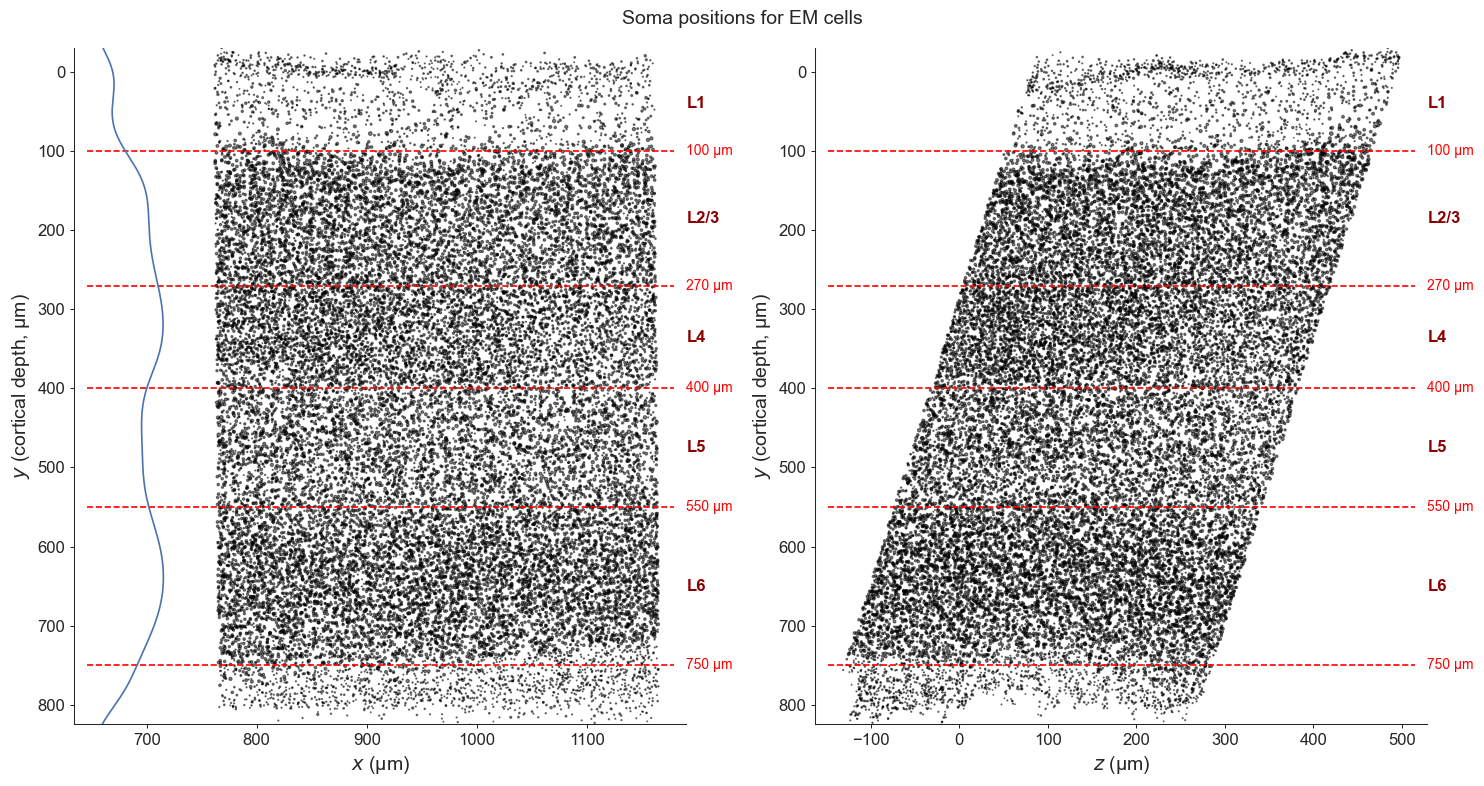

In [44]:
# Visualize the depths of these cells
x_pos = nearby_cells.position_microns.apply(lambda pos: pos[0])
y_pos = nearby_cells.position_microns.apply(lambda pos: pos[1])
z_pos = nearby_cells.position_microns.apply(lambda pos: pos[2])
point_sizes = nearby_cells.volume * 0.01
fig, axs = plt.subplots(figsize=(15, 8), ncols=2)

# Normalize the y points
# q = 0.005
# y_min, y_max = np.quantile(y, [q, 1-q])
# y = (y - y_min) / (y_max - y_min) * y_max

fig.suptitle("Soma positions for EM cells", fontsize=14)

for ax, x, xlabel in [
    (axs[0], x_pos, "x"),
    (axs[1], z_pos, "z"),
]:
    ax.scatter(x, y_pos, color="black", s=point_sizes, alpha=0.5)
    ax.set_xlabel(f"${xlabel}$ (µm)", fontsize=14)
    ax.set_ylabel("$y$ (cortical depth, µm)", fontsize=14)

    ax.set_ylim(y_pos.min(), y_pos.max())
    ax.invert_yaxis() # Open down

    # Shade depth chunks
    # 200-300, 300-400, 400-500, 500-600
    #    G        W        G        W
    # ax.axhspan(ymin=200, ymax=300, color="gray", alpha=0.2)
    # ax.axhspan(ymin=400, ymax=500, color="gray", alpha=0.2)

    # Convention used in Ji et al., 2016; Bertrero et al., 2020
    # for d in (160, 375, 520, 790):
    #     ax.axhline(y=d, color="red", linestyle="dashed")

    # Approximate fit for our data
    text_trans = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)

    for layer, (depth_min, depth_max) in em_client.layer_boundaries.items():
        ax.axhline(depth_max, xmin=0.02, xmax=0.98, color="red", linestyle="dashed")
        ax.text(1, depth_max, f"{depth_max} µm", ha="left", va="center", color="red", fontsize=10, transform=text_trans)
        text_depth = depth_max - 60 if np.isinf(depth_min) else (depth_min + depth_max) / 2
        ax.text(1, text_depth, f"L{layer}", ha="left", va="center", color="darkred", fontweight="bold", transform=text_trans)

    # for i, depth in enumerate(layer_boundaries):
    #     ax.axhline(depth, xmin=0.02, xmax=0.98, color="red", linestyle="dashed")
    #     ax.text(1, depth, f"{depth} µm", ha="left", va="center", color="red", fontsize=10, transform=mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData))

    #     if i < len(layer_names):
    #         layer = layer_names[i]
    #         layer_text_y = depth + (layer_boundaries[i+1]-depth)/2
    #         ax.text(1, layer_text_y, f"L{layer}", ha="left", va="center", color="darkred", fontweight="bold", transform=mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData))

center_pos_microns = em_client.transform_position_to_microns(center_position_voxels)
print("Center position =", center_pos_microns)

kde = st.gaussian_kde(y_pos)
kde_range = np.linspace(y_pos.min(), y_pos.max(), 500)
kde_start_x = 650
axs[0].plot(kde_start_x + kde(kde_range) * 40000, kde_range)

fig.tight_layout()